This section explores the concept of latent space communication and demonstrates how relative representations can create stable latent spaces across different learning models. Specifically, this section of the paper addresses whether the latent embeddings of two independently trained models on different datasets(but same subjects) can be compared effectively. By using relative representations, the study shows that semantically equivalent latent spaces can communicate effectively.

In [1]:
import gensim.downloader as api
import torch
import random
import numpy as np
import os
from torch.nn.functional import normalize
from torch import cosine_similarity
from pytorch_lightning import seed_everything
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import requests, zipfile
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE


# number of pivot words(clusters of same semantics)
num_pivots = 4

# number of most similar words to pivot words
top_k = 200

# choosing top_k among top_similar words to pivot words
top_similar = 5000

# Ensure reproducibility
seed = 21

# input range in visualizing plots of latents
plot_lim = 5

# number of anchors for relative represntation dimensions to compute the similarity
num_anchors = 300

The function for computing the cosine similarity normalizes two vectors $\mathbf{anchors}$ and $\mathbf{x}$ in the following way:
$$
\hat{\mathbf{anchors}} = \frac{\mathbf{anchors}}{\|\mathbf{anchors}\|} \text{, } \hat{\mathbf{x}} = \frac{\mathbf{x}}{\|\mathbf{x}\|}
$$
Then dot product between two vectors $\mathbf{anchors}$ and $\mathbf{x}$ is computed to get:

$$
\text{cosine similarity} = \cos(\theta) = \hat{\mathbf{anchors}} \cdot \hat{\mathbf{x}}
$$


In [2]:
def relative_projection(x, anchors):
    x = normalize(x, p=2, dim=-1)
    anchors = normalize(anchors, p=2, dim=-1)
    return torch.einsum("bm, am -> ba", x, anchors)


def get_relative(vectors, anchor_ids):
    anchor_latents = vectors[anchor_ids]
    relative_vectors = relative_projection(x=vectors, anchors=anchor_latents)
    return relative_vectors

In [3]:
# method of choosing anchors (uniform sampling)
def get_anchor_ids(num_anchors, num_latents):
    # Select anchors
    seed_everything(seed)
    anchor_set = random.sample(range(num_latents), num_anchors)
    result = sorted(anchor_set)
    return result

# given two encoders returns shared vocabulary
def get_shared_vocabulary(encoder1, encoder2):
    vocab1 = set(encoder1.key_to_index.keys())
    vocab2 = set(encoder2.key_to_index.keys())
    return list(vocab1.intersection(vocab2))

the following is the instruction of loading news dataest using fasttext from facebook research fasttext models

In [4]:
# Step 1: Download the file
dataset = "wiki-news-300d-1M.vec"
url = f"https://dl.fbaipublicfiles.com/fasttext/vectors-english/{dataset}.zip"
response = requests.get(url)
with open("wiki-news-300d-1M.vec.zip", "wb") as f:
    f.write(response.content)

# Step 2: Extract the file
with zipfile.ZipFile("wiki-news-300d-1M.vec.zip", "r") as zip_ref:
    zip_ref.extractall()


# Step 3: Load the vectors into gensim
fasttext_model = KeyedVectors.load_word2vec_format(dataset, binary=False)

also loading similar problem word2vec model

In [5]:
ENCODERS = {
    "fasttext": fasttext_model,
    "word2vec": api.load("word2vec-google-news-300"),
}

[==================================================] 100.0% 1662.8/1662.8MB downloaded


results may be different from that of paper since original paper uses a fasttext model in which the dataset is not clearly mentioned and according to paper has far less shared!! vocabulary size

In [6]:
shared_vocab = get_shared_vocabulary(ENCODERS["word2vec"], ENCODERS["fasttext"])

in order to qualitatively show that similar words fall into the same cluster of latents, limited number of words are chosen from shared vocabulary. then, top-k similar shared-words with respect to each pivot words are taken to compute latents

In [7]:
# Select 4 random pivot words
seed_everything(seed)
pivot_words = random.sample(shared_vocab, num_pivots)
print(f"clusters similar words are associated to :{pivot_words}")

      
visualization_words = []
associated_labels = []
for NO_pivot, pivot in enumerate(pivot_words):
    neighbors_w2v = [similar_word for similar_word, _ in 
                     ENCODERS["word2vec"].most_similar(pivot, topn=top_similar)]
    neighbors_ft = [similar_word for similar_word, _ in 
                    ENCODERS["fasttext"].most_similar(pivot, topn=top_similar)]
    shared_neighbors = set(neighbors_w2v).intersection(neighbors_ft)
    visualization_words.extend(list(shared_neighbors)[:top_k])
    associated_labels.extend([NO_pivot+1] * len(list(shared_neighbors)[:top_k]))

clusters similar words are associated to :['Asali', 'Vatanen', 'roundhouses', 'Bougher']


the latent of each word is computed according to each encoder
absolute latent of each cluster deem to be uncorrelated with the other encoder

In [8]:
# get absolute representations of selected words among the shared vocabulary
word2vec_absolute_latents = torch.tensor([ENCODERS["fasttext"][word]
                                       for word in visualization_words])
fasttext_absolute_latents = torch.tensor([ENCODERS["word2vec"][word]
                                       for word in visualization_words])
      
# The shape is [num_samples, hidden_dim]
print(word2vec_absolute_latents.shape, fasttext_absolute_latents.shape)

# Compare the absolute latents --> low similarity since there is an isometry
cosine_similarity(word2vec_absolute_latents, fasttext_absolute_latents).mean()

torch.Size([713, 300]) torch.Size([713, 300])


/tmp/ipykernel_18/1477207559.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  word2vec_absolute_latents = torch.tensor([ENCODERS["fasttext"][word]


tensor(-0.0109)

this is also shown in scatter plots as each cluster is brought down to 2 dimension for visualization purposes

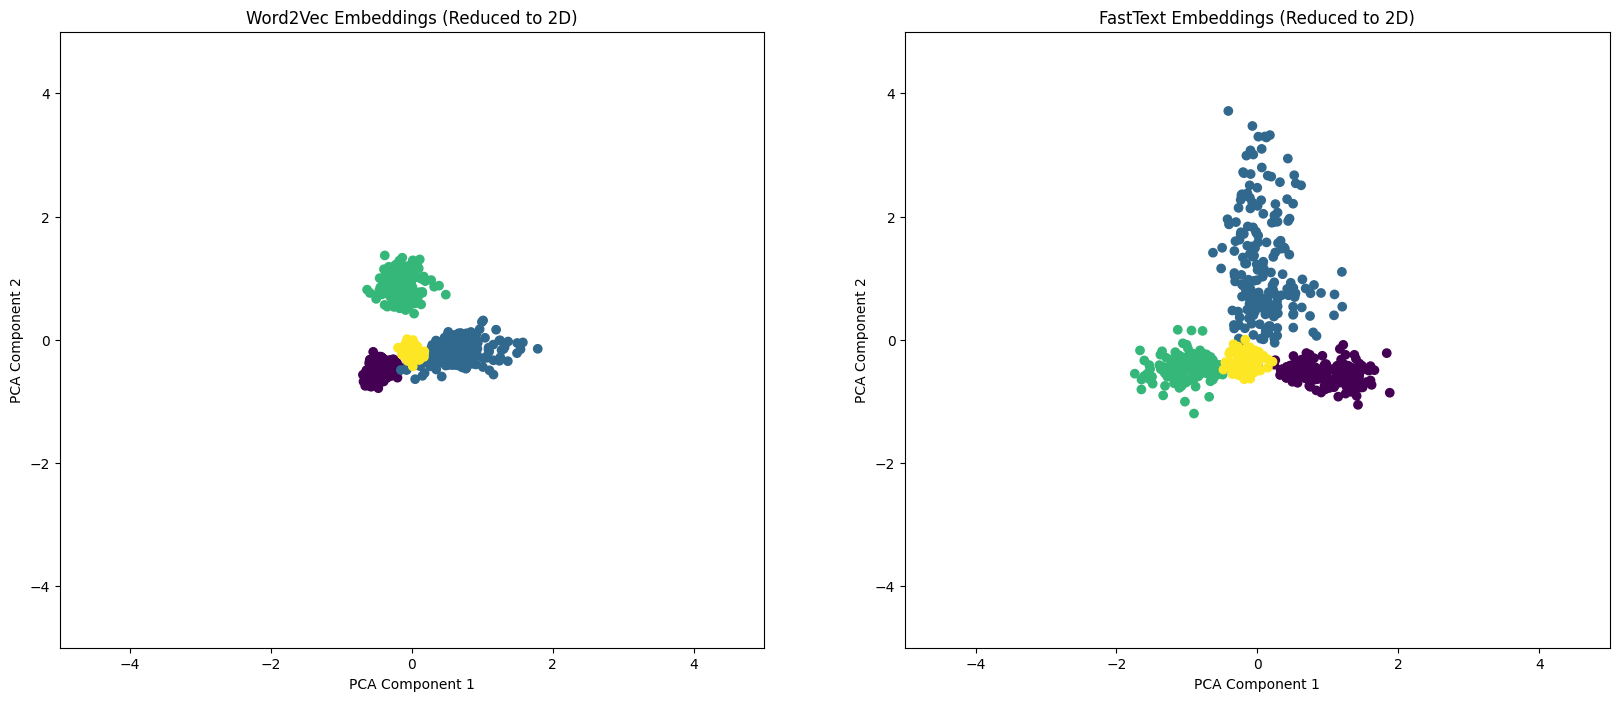

In [9]:
# Reduce dimensionality to 2 using PCA or TSNE 
# you can choose between the two and both methods are mentioned in the paper
reduce_dim_method = TSNE(n_components=2)
reduce_dim_method = PCA(n_components=2)

word2vec_absolute_reps_2d = reduce_dim_method.fit_transform(word2vec_absolute_latents.numpy())

# reduce_dim_method = PCA(n_components=2)
fasttext_absolute_reps_2d = reduce_dim_method.fit_transform(fasttext_absolute_latents.numpy())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].set_xlim((-plot_lim, plot_lim))
axs[0].set_ylim((-plot_lim, plot_lim))
# Plot Word2Vec embeddings
axs[0].scatter(word2vec_absolute_reps_2d[:, 1], word2vec_absolute_reps_2d[:, 0], c=associated_labels)
axs[0].set_title("Word2Vec Embeddings (Reduced to 2D)")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

axs[1].set_xlim((-plot_lim, plot_lim))
axs[1].set_ylim((-plot_lim, plot_lim))
# Plot FastText embeddings
axs[1].scatter(fasttext_absolute_reps_2d[:, 1], fasttext_absolute_reps_2d[:, 0], c=associated_labels)
axs[1].set_title("FastText Embeddings (Reduced to 2D)")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

plt.savefig('absolute_latents.png')
plt.show()


Thereafter, we sample anchor indices accoring to a uniform distribution to compute relative representation using the chosen measure of similarity
we can observe latents of two models are highly similar while having different models

In [10]:
# Get some anchors
anchor_ids = get_anchor_ids(num_anchors, num_latents=len(associated_labels))

# Transform both spaces w.r.t. the same anchors
word2vec_relative_latents = get_relative(word2vec_absolute_latents, anchor_ids)
fasttext_relative_latents = get_relative(fasttext_absolute_latents, anchor_ids)

# The shape is [num_samples, num_anchors]
print(word2vec_relative_latents.shape, fasttext_relative_latents.shape)

# Compare the relative spaces --> perfect similarity, since we are invariant to isometries
cosine_similarity(word2vec_relative_latents, fasttext_relative_latents).mean()

torch.Size([713, 300]) torch.Size([713, 300])


tensor(0.8856)

this is also verified using scatter plots of data

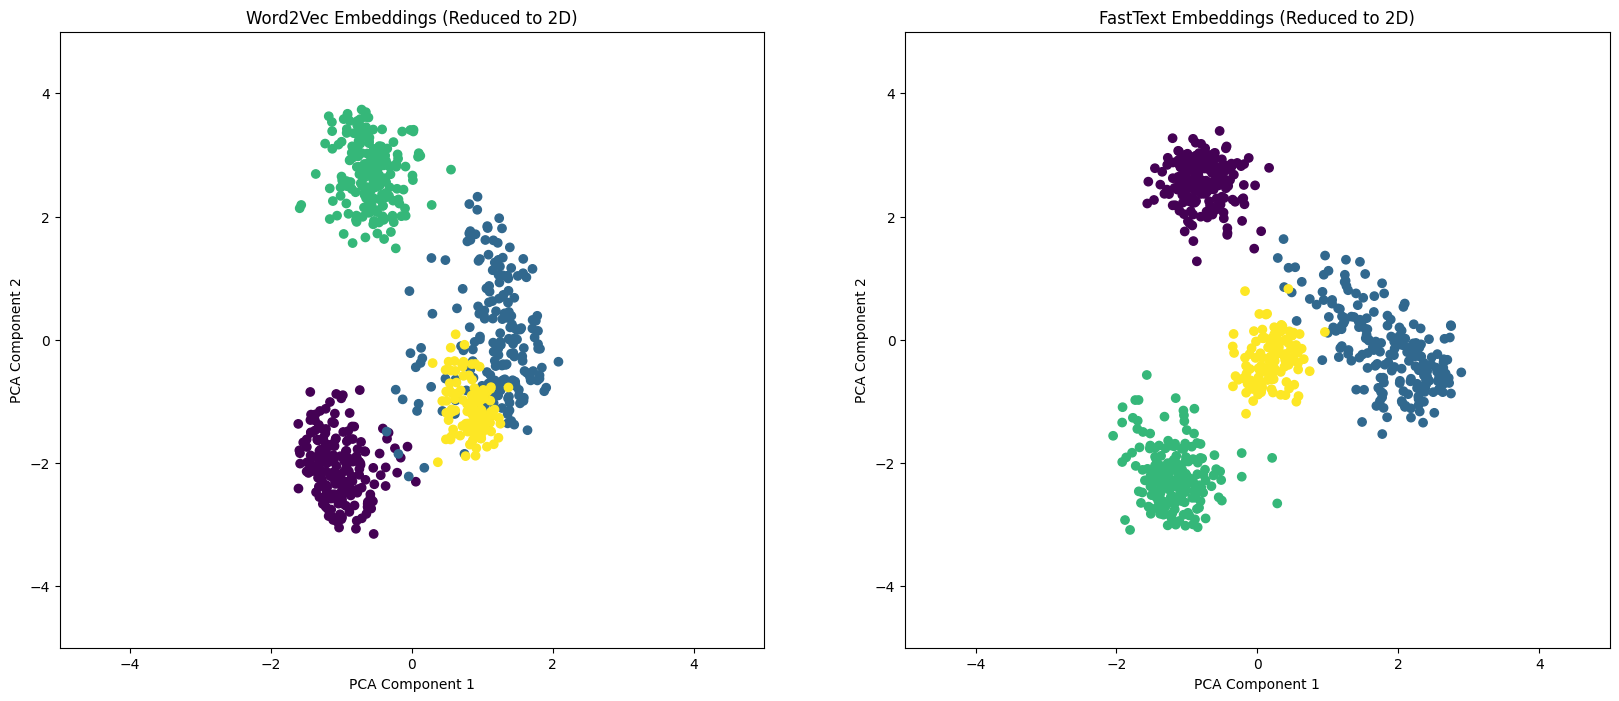

In [11]:
# Reduce dimensionality to 2 using PCA

# reduce_dim_method = PCA(n_components=2)
word2vec_relative_reps_2d = reduce_dim_method.fit_transform(word2vec_relative_latents.numpy())

# reduce_dim_method = PCA(n_components=2)
fasttext_relative_reps_2d = reduce_dim_method.fit_transform(fasttext_relative_latents.numpy())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot Word2Vec embeddings
axs[0].set_xlim((-plot_lim, plot_lim))
axs[0].set_ylim((-plot_lim, plot_lim))
axs[0].scatter(word2vec_relative_reps_2d[:, 1], word2vec_relative_reps_2d[:, 0], c=associated_labels)
axs[0].set_title("Word2Vec Embeddings (Reduced to 2D)")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

# Plot FastText embeddings
axs[1].set_xlim((-plot_lim, plot_lim))
axs[1].set_ylim((-plot_lim, plot_lim))
axs[1].scatter(fasttext_relative_reps_2d[:, 1], fasttext_relative_reps_2d[:, 0], c=associated_labels)
axs[1].set_title("FastText Embeddings (Reduced to 2D)")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

plt.savefig('relative_latents.png')
plt.show()